================================================================================

IMDB REVIEWS EDA - Elina Nussbaum

Are negative remarks longer?

Are positive remarks better spelled?

Can we use words from negative and positive remarks to identify sentiments in other datasets?

Does a commonly used sentiment analyzer match the sentiment provided in the dataset?

================================================================================

==> Load file to local environment - load from drive

In [1]:
from google.colab import files
uploaded = files.upload()

Saving IMDB_Dataset.csv to IMDB_Dataset.csv


==> Install all modules

In [2]:
# data analysis libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px

# english dictionary
!apt -qq install enchant
!pip install pyenchant
import enchant
en_dictionary = enchant.Dict("en_US")

# text filtering tools
from bs4 import BeautifulSoup
import string

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
# from nltk.stem.porter import PorterStemmer
# porter = PorterStemmer()

# sentiment analyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
nltk_sent = SentimentIntensityAnalyzer()

# profanity checkers 
!pip install better_profanity
from better_profanity import profanity
!pip install profanity-check
from profanity_check import predict, predict_prob

The following additional packages will be installed:
  aspell aspell-en dictionaries-common emacsen-common hunspell-en-us
  libaspell15 libenchant1c2a libhunspell-1.6-0 libtext-iconv-perl
Suggested packages:
  aspell-doc spellutils wordlist hunspell openoffice.org-hunspell
  | openoffice.org-core libenchant-voikko
The following NEW packages will be installed:
  aspell aspell-en dictionaries-common emacsen-common enchant hunspell-en-us
  libaspell15 libenchant1c2a libhunspell-1.6-0 libtext-iconv-perl
0 upgraded, 10 newly installed, 0 to remove and 14 not upgraded.
Need to get 1,310 kB of archives.
After this operation, 5,353 kB of additional disk space will be used.
Preconfiguring packages ...
Selecting previously unselected package libtext-iconv-perl.
(Reading database ... 144865 files and directories currently installed.)
Preparing to unpack .../0-libtext-iconv-perl_1.7-5build6_amd64.deb ...
Unpacking libtext-iconv-perl (1.7-5build6) ...
Selecting previously unselected package libaspe

/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning:

The twython library has not been installed. Some functionality from the twitter package will not be available.



     |████████████████████████████████| 51kB 2.5MB/s 
     |████████████████████████████████| 2.4MB 5.9MB/s 


/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning:

sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning:

Trying to unpickle estimator CountVectorizer from version 0.20.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.svm.classes module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.svm. Anything that cannot be imported from sklearn.svm is now part of the private API.


==> Load and process IMDB reviews

In [8]:
imdb_reviews = pd.read_csv("IMDB_Dataset.csv")
imdb_reviews.dropna(inplace = True) 
print("Shape of the IMDB dataset:", imdb_reviews.shape)
print(imdb_reviews.head(20))

Shape of the IMDB dataset: (50000, 2)
                                               review sentiment
0   One of the other reviewers has mentioned that ...  positive
1   A wonderful little production. <br /><br />The...  positive
2   I thought this was a wonderful way to spend ti...  positive
3   Basically there's a family where a little boy ...  negative
4   Petter Mattei's "Love in the Time of Money" is...  positive
5   Probably my all-time favorite movie, a story o...  positive
6   I sure would like to see a resurrection of a u...  positive
7   This show was an amazing, fresh & innovative i...  negative
8   Encouraged by the positive comments about this...  negative
9   If you like original gut wrenching laughter yo...  positive
10  Phil the Alien is one of those quirky films wh...  negative
11  I saw this movie when I was about 12 when it c...  negative
12  So im not a big fan of Boll's work but then ag...  negative
13  The cast played Shakespeare.<br /><br />Shakes...  negative
14

==> Review split by sentiment

AxesSubplot(0.125,0.125;0.775x0.755)


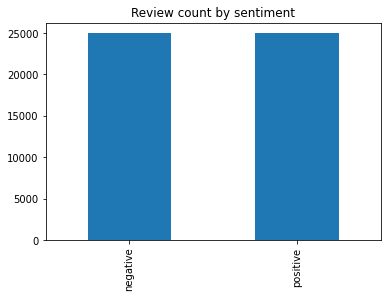

In [7]:
count_reviews_by_sentiment = imdb_reviews['sentiment'].value_counts()
ax_sent = count_reviews_by_sentiment.plot.bar()
ax_sent.set_title("Review count by sentiment")
print(ax_sent)

Remark length per sentiment


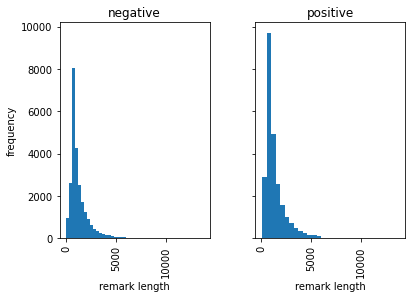

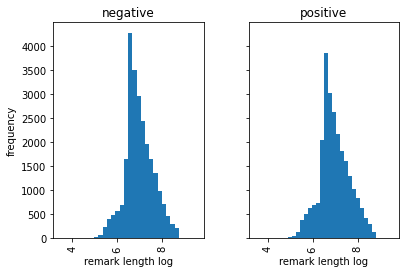

In [10]:
imdb_reviews["remark_len"] = imdb_reviews["review"].str.len()
imdb_reviews["remark_len_log"] = np.log(imdb_reviews["remark_len"])

print("Remark length per sentiment")
ax_remark_len  = imdb_reviews.hist(column='remark_len', by='sentiment', bins=30, sharex=True, sharey=True)
for x_sentiment in ax_remark_len:
  x_sentiment.set_ylabel("frequency")
  x_sentiment.set_xlabel("remark length")

ax_remark_len_log  = imdb_reviews.hist(column='remark_len_log', by='sentiment', bins=30, sharex=True, sharey=True)
for x_sentiment in ax_remark_len_log:
  x_sentiment.set_ylabel("frequency")
  x_sentiment.set_xlabel("remark length log")



In [11]:
#clear html tags
reviews_without_html = imdb_reviews["review"].apply(lambda x: BeautifulSoup(x, "lxml").text.lower())
# print(reviews_without_html)

#clear invalid chars
exclist = string.punctuation + string.digits
table = str.maketrans('', '', exclist)
reviews_words_only = reviews_without_html.apply(lambda x: x.translate(table).strip())
# print(reviews_words_only)

#split into unique words
all_words = reviews_words_only.apply(lambda x: x.split())
unique_words = all_words.apply(lambda x: set(x))
# imdb_reviews["cnt_unique_words"] = unique_words.str.len()
# print(unique_words)

#valid words that are not stop words
valid_words = unique_words.apply(lambda x: [word for word in x if len(word) > 0 and en_dictionary.check(word) and not word in stop_words])
# print(valid_words)

# stem words
# stem_words = valid_words.apply(lambda x: sorted(set([porter.stem(word) for word in x])))
# print(stem_words)

imdb_reviews["all_words"] = all_words
imdb_reviews["cnt_words"] = all_words.apply(lambda x: len(x))
imdb_reviews["cnt_unique_words"] = unique_words.apply(lambda x: len(x))
imdb_reviews["cnt_valid_words"] = valid_words.apply(lambda x: len(x))
imdb_reviews["valid_words"] = valid_words
# imdb_reviews["cnt_stem_words"] = stem_words.apply(lambda x: len(x))
# imdb_reviews["final_words_list"] = stem_words
imdb_reviews.head()

,review,sentiment,remark_len,remark_len_log,all_words,cnt_words,cnt_unique_words,cnt_valid_words,valid_words
0,One of the other reviewers has mentioned that ...,positive,1761,7.473637,"[one, of, the, other, reviewers, has, mentione...",300,189,122,"[violence, hooked, pulls, fronts, episode, sho..."
1,A wonderful little production. <br /><br />The...,positive,998,6.905753,"[a, wonderful, little, production, the, filmin...",156,106,69,"[piece, comes, voices, unassuming, written, pa..."
2,I thought this was a wonderful way to spend ti...,positive,926,6.830874,"[i, thought, this, was, a, wonderful, way, to,...",161,116,75,"[characters, killer, serial, laughed, suspecte..."
3,Basically there's a family where a little boy ...,negative,748,6.617403,"[basically, theres, a, family, where, a, littl...",128,82,46,"[decide, thriller, expected, suddenly, watchab..."
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1317,7.183112,"[petter, matteis, love, in, the, time, of, mon...",222,141,82,"[anxiously, human, best, characters, lonelines..."


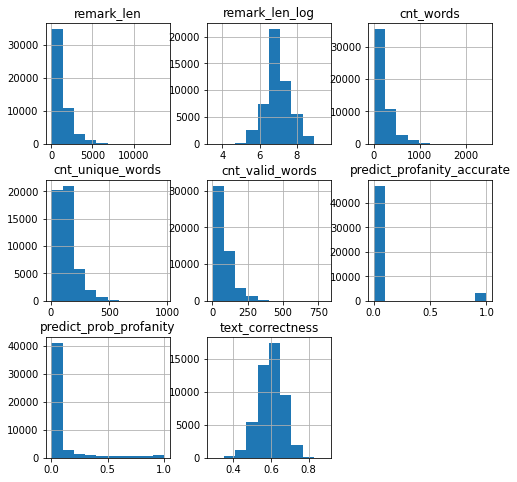

In [12]:
imdb_reviews["valid_words_str"] = imdb_reviews["valid_words"].apply(lambda x: ' '.join(x))

# bad library, SLOW!
# imdb_reviews["contains_profanity"] = imdb_reviews["valid_words_str"].apply(profanity.contains_profanity)
# print(imdb_reviews["contains_profanity"].describe(include="all"))

imdb_reviews["predict_profanity_accurate"] = predict(imdb_reviews["valid_words_str"])
imdb_reviews["predict_prob_profanity"] = predict_prob(imdb_reviews["valid_words_str"])
# print(imdb_reviews["predict_profanity_accurate"].describe(include="all"))
# imdb_reviews.head()

imdb_reviews["text_correctness"] = imdb_reviews["cnt_valid_words"]/imdb_reviews["cnt_unique_words"]

ax = imdb_reviews.hist(figsize=(8, 8))

Text spelling correctness


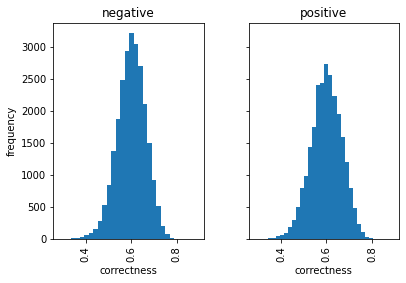

In [13]:
print ("Text spelling correctness")
ax_text_correctness  = imdb_reviews.hist(column='text_correctness', by='sentiment', bins=30, sharex=True, sharey=True)
for x_sentiment in ax_text_correctness:
  x_sentiment.set_ylabel("frequency")
  x_sentiment.set_xlabel("correctness")

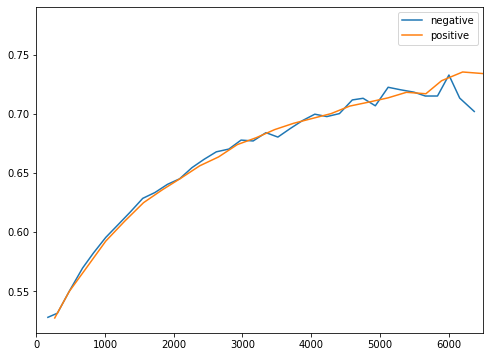

In [14]:
#avg correctness by avg len
fig, ax = plt.subplots(figsize=(8,6))
for label, df in imdb_reviews.groupby('sentiment'):
  plt.xlim(0,6500)
  tmp = df.groupby(pd.cut(df["remark_len"],50)).mean()
  plt.plot(tmp["remark_len"],tmp["text_correctness"],label=label,)
plt.legend()

sentiment
negative    2626
positive     421
Name: predict_profanity_accurate, dtype: int64


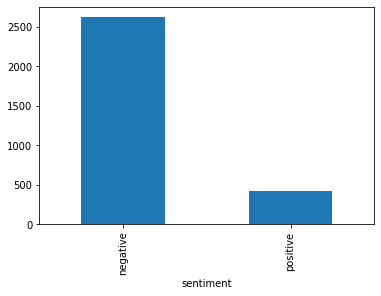

In [16]:
group_by_sentiment = imdb_reviews.groupby('sentiment').sum()
print(group_by_sentiment['predict_profanity_accurate'])
group_by_sentiment['predict_profanity_accurate'].plot(kind="bar")

# profanity_by_sentiment = imdb_reviews.groupby('sentiment')['predict_profanity_accurate'].sum()
# imdb_reviews.groupby('sentiment').agg({'predict_profanity_accurate': sum})

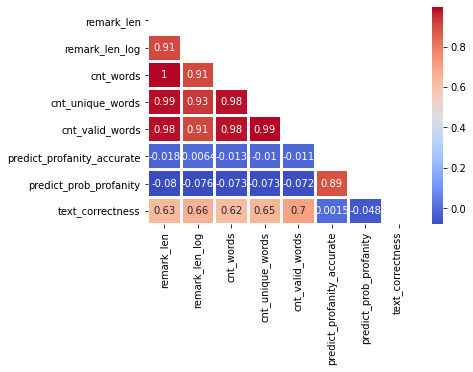

In [18]:
# longer texts usually have better spelling
corr= imdb_reviews.corr()
matrix = np.triu(corr)
sns.heatmap(imdb_reviews.corr(), cmap="coolwarm",linewidths=2,mask=matrix,annot=True)

In [ ]:
all_words = imdb_reviews["valid_words_str"].str.cat(sep=' ')
dist_words = pd.Series(sorted(set(all_words.split())))

positive_reviews = imdb_reviews[imdb_reviews['sentiment']=='positive']["all_words"].values
negative_reviews = imdb_reviews[imdb_reviews['sentiment']=='negative']["all_words"].values

cnt_in_negative = dist_words.apply(lambda x: len([1 for review in negative_reviews if x in review]))
cnt_in_positive = dist_words.apply(lambda x: len([1 for review in positive_reviews if x in review]))
# print(cnt_in_negative)
# print(cnt_in_positive)

word_data = {'word': dist_words,
        'cnt_in_negative': cnt_in_negative,
        'cnt_in_positive': cnt_in_positive}

words_in_reviews = pd.DataFrame(word_data)
words_in_reviews["cnt_in_reviews"] = words_in_reviews["cnt_in_negative"] + words_in_reviews["cnt_in_positive"]
words_in_reviews.head()

,word,cnt_in_negative,cnt_in_positive,cnt_in_reviews
0,aah,1,1,2
1,aardvark,0,1,1
2,aardvarks,0,2,2
3,ab,6,14,20
4,aback,6,13,19


In [ ]:
print("total valid words : ", len(words_in_reviews.index))
avg_occ = words_in_reviews["cnt_in_reviews"].mean()
common_words = words_in_reviews[words_in_reviews['cnt_in_reviews'] >= avg_occ]
print("total words with over avg num of occurrences : ", len(common_words.index))

total valid words :  45012
total words with over avg num of occurrences :  5530


In [ ]:
top_neg_words = words_in_reviews.sort_values(by="cnt_in_negative", ascending=False).head(40)
px.bar(top_neg_words, x="cnt_in_negative", y="word", title='top words in negative remarks', orientation='h', 
             width=700, height=700,color='word')

In [ ]:
top_pos_words = words_in_reviews.sort_values(by="cnt_in_positive", ascending=False).head(40)
px.bar(top_pos_words, x="cnt_in_positive", y="word", title='top words in positive remarks', orientation='h', 
             width=700, height=700,color='word')

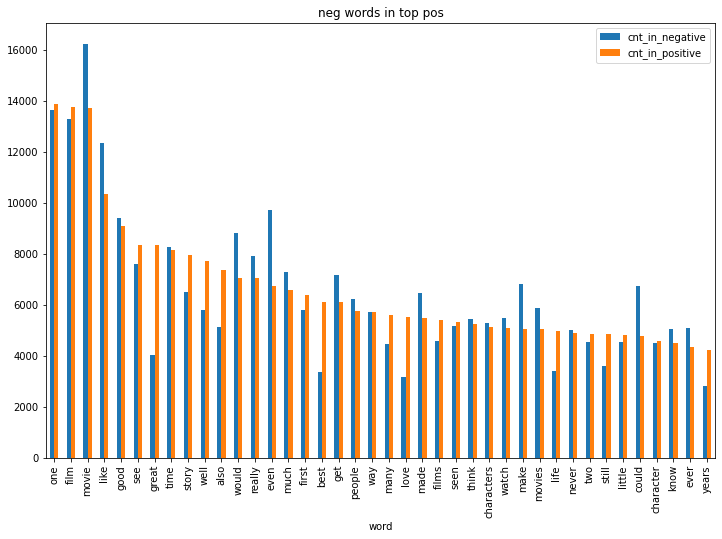

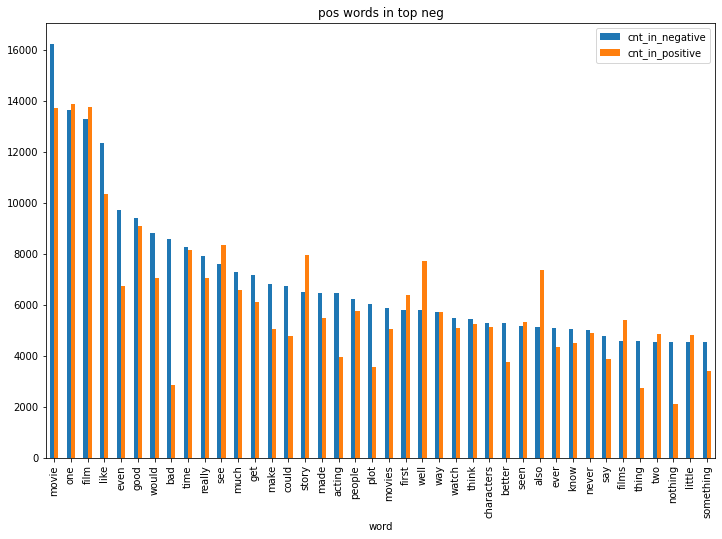

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
top_pos_words.plot("word",["cnt_in_negative","cnt_in_positive"],kind="bar",ax=ax, title="neg words in top pos")

fig, ax = plt.subplots(figsize=(12,8))
top_neg_words.plot("word",["cnt_in_negative","cnt_in_positive"],kind="bar",ax=ax, title="pos words in top neg")

In [ ]:
imdb_reviews['is_positive_analysis'] = imdb_reviews['review'].apply(lambda x: nltk_sent.polarity_scores(x)['compound'] >= 0)
imdb_reviews.groupby('sentiment').agg({'sentiment' : 'count', 'is_positive_analysis': 'sum'})

/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning:

The twython library has not been installed. Some functionality from the twitter package will not be available.



[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


,sentiment,is_positive_analysis
sentiment,,
negative,25000,11636
positive,25000,21402


In [ ]:
words_in_reviews.to_csv("words_in_reviews_50000.csv")

In [ ]:
imdb_reviews.to_csv("imdb_reviews_50000.csv")